## Script to compare the climate timeseries produced using different methods
Script to compare aerial climate timeseries produced by different methods. This example script was used to compare timeseries produced through Rob's pre-processor Veneer approach in the script called "Climate_TS_Production" and those produced using Joel's climate-utils. Note, the timeseries are pre-prepared and just need to point them to the two paths containing the climate TS files.

### Note: The lengths of the files need to be the same size (i.e. same number of SCs files, and same dates for the files)

In [1]:
%matplotlib inline
import climate_utils
import shapely
import rasterio
import os
import string
import glob
from glob import glob
import numpy as np
import pandas as pd
import sys
from datetime import datetime,timedelta
import requests
import json

In [2]:
ROB_PATH='D:\\Climate_extension\\outputTS\\Jan1970_Mar2018\\MW'  #Timeseries produced using Rob's climate extension veneer tool
JOEL_PATH='D:\\Jupyter_notebooks\\ExtendClimate_MW\\MW_extended_timeseries_JoelMethod' #Timeseries produced using Joel's Source veneer tool & webserver monitoring into actual model

ABSOLUTE_TOLERANCE=2.5 # mm/day
RELATIVE_TOLERANCE=10 # %

In [3]:
#Settings

Rob_file_path = os.path.join(ROB_PATH,'*.csv')
Joel_file_path= os.path.join(JOEL_PATH,'*.csv')

VARIABLES=['rainfall','pet']
VARIABLES_JOEL=['rainfall','pet']
VARIABLE_MAP=dict(zip(VARIABLES_JOEL,VARIABLES))
START='1970/1/1'
END='2017/03/31'

In [4]:
VARIABLE_MAP

{'pet': 'pet', 'rainfall': 'rainfall'}

In [5]:
def joel_fn_to_rob_fn(joel_fn):
#     print(joel_fn)
    catchment_number = joel_fn.split('#')[1].split('.')[0]
#     print(joel_fn.split("#"))
#     print(catchment_number)
    variable = os.path.basename(joel_fn).split(' ',1)[0]
#     print(os.path.basename(joel_fn))
    rob_var = VARIABLE_MAP[variable]
#     print(rob_var)
    rob_fn = '%s for SC #%s.csv'%(rob_var,catchment_number)
#     print(rob_fn)
    return os.path.join(ROB_PATH,rob_fn)

In [6]:
Rob_file_path


'D:\\Climate_extension\\outputTS\\Jan1970_Mar2018\\MW\\*.csv'

In [7]:
import glob
Rob_filenames = glob.glob(Rob_file_path)
len(Rob_filenames)

406

In [8]:
Joel_filenames = glob.glob(Joel_file_path)
len(Joel_filenames)

406

In [9]:
Joel_filenames[0]

'D:\\Jupyter_notebooks\\ExtendClimate_MW\\MW_extended_timeseries_JoelMethod\\pet for SC #1.csv'

In [10]:
# for joel_fn in Joel_filenames:
#     rob_fn = joel_fn_to_rob_fn(joel_fn)
    
#     joel_df = pd.read_csv(joel_fn,index_col=0)
#     rob_df = pd.read_csv(rob_fn,index_col=0)

In [11]:
# joel_df

In [12]:
#rob_df

,rainfall for SC #99
Date,
1970-01-01,0.0
1970-01-02,0.7
1970-01-03,0.0
1970-01-04,0.0
1970-01-05,0.0
1970-01-06,0.0
1970-01-07,0.0
1970-01-08,0.0
1970-01-09,0.0


In [13]:
# joel_fn_to_rob_fn(Joel_filenames[0])

'D:\\Climate_extension\\outputTS\\Jan1970_Mar2018\\MW\\pet for SC #1.csv'

In [14]:

print('. - no significant differences, 1 - absolute difference, 2 - relative difference, 3 - absolute and relative difference')
print()

differences = []
i=0
for joel_fn in Joel_filenames:
    rob_fn = joel_fn_to_rob_fn(joel_fn)
    
    joel_df = pd.read_csv(joel_fn,index_col=0)
    rob_df = pd.read_csv(rob_fn,index_col=0)

    assert len(joel_df.columns)==1
    assert len(rob_df.columns)==1

    joel_df = joel_df[joel_df.columns[0]] # Get first column
    rob_df = rob_df[rob_df.columns[0]]
    
    assert len(joel_df)==len(rob_df)

    diff = joel_df - rob_df

    i += 1
    errors = 0
    record = [joel_fn,rob_fn,joel_df,rob_df]

    max_abs_error = abs(diff.max().max())
    ts_max_abs_error = np.argmax(abs(diff))

    if max_abs_error > ABSOLUTE_TOLERANCE:
        errors += 1
    
    relative_diff = diff / rob_df
    #relative_diff[np.isnan(relative_diff)] = 1.0
    relative_diff = relative_diff.dropna()
    relative_diff *= 100
    max_relative_error = abs(relative_diff.max().max())
    ts_max_rel_error = np.nanargmax(abs(relative_diff))
    if max_relative_error > RELATIVE_TOLERANCE:
        errors += 2

    if errors:
        record.append(max_abs_error)
        record.append(max_relative_error)
        record.append(ts_max_abs_error)
        record.append(ts_max_rel_error)
        record.append(errors)
        differences.append(record)
        print(errors,end='')
    else:
        print('.',end='')

    if (i%100)==0:
        print()

len(differences)

. - no significant differences, 1 - absolute difference, 2 - relative difference, 3 - absolute and relative difference

....

C:\Users\askildsenm\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


................................................................................................
....................................................................................................
...3322222222223222222222232222333333333333333333333333233333332332223332322233323333333233233333333
2333333333333333333333333333333333333333322222332333333233333333333333333333333332223333333333233333
323222

203

In [15]:
summary_diffs = [(d[0],d[1],d[4],d[5],d[6],d[7],d[8]) for d in differences]
summary_diffs = pd.DataFrame(summary_diffs,columns=['j_fn','r_fn','max_abs_error','max_rel_error','ts_max_abs_error','ts_max_rel_error','error_code'])

In [16]:
print('Number of time series pairs with significant differences',len(summary_diffs))
print('Number of unique time steps on which the maximum absolute difference occurs',len(set(summary_diffs['ts_max_abs_error'])))

Number of time series pairs with significant differences 203
Number of unique time steps on which the maximum absolute difference occurs 20


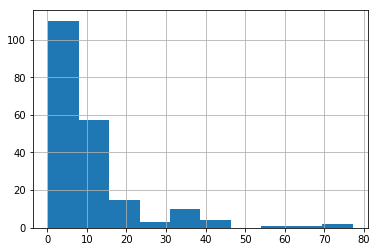

In [17]:
summary_diffs['max_abs_error'].hist()

In [18]:
summary_diffs[np.isfinite(summary_diffs['max_rel_error'])]['max_rel_error'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: max_rel_error, dtype: float64

In [19]:
summary_diffs

,j_fn,r_fn,max_abs_error,max_rel_error,ts_max_abs_error,ts_max_rel_error,error_code
0,D:\Jupyter_notebooks\ExtendClimate_MW\MW_exten...,D:\Climate_extension\outputTS\Jan1970_Mar2018\...,4.880662,inf,2013-11-23,6382,3
1,D:\Jupyter_notebooks\ExtendClimate_MW\MW_exten...,D:\Climate_extension\outputTS\Jan1970_Mar2018\...,5.078232,inf,2013-11-23,7275,3
2,D:\Jupyter_notebooks\ExtendClimate_MW\MW_exten...,D:\Climate_extension\outputTS\Jan1970_Mar2018\...,0.763656,inf,2013-12-01,8495,2
3,D:\Jupyter_notebooks\ExtendClimate_MW\MW_exten...,D:\Climate_extension\outputTS\Jan1970_Mar2018\...,0.881036,inf,2015-11-08,7646,2
4,D:\Jupyter_notebooks\ExtendClimate_MW\MW_exten...,D:\Climate_extension\outputTS\Jan1970_Mar2018\...,0.893410,inf,2015-11-08,7935,2
5,D:\Jupyter_notebooks\ExtendClimate_MW\MW_exten...,D:\Climate_extension\outputTS\Jan1970_Mar2018\...,1.580109,inf,2013-12-01,7544,2
6,D:\Jupyter_notebooks\ExtendClimate_MW\MW_exten...,D:\Climate_extension\outputTS\Jan1970_Mar2018\...,1.605380,inf,2013-12-01,7762,2
7,D:\Jupyter_notebooks\ExtendClimate_MW\MW_exten...,D:\Climate_extension\outputTS\Jan1970_Mar2018\...,2.100000,inf,2013-12-01,6630,2
8,D:\Jupyter_notebooks\ExtendClimate_MW\MW_exten...,D:\Climate_extension\outputTS\Jan1970_Mar2018\...,2.100000,inf,2013-12-01,6630,2
9,D:\Jupyter_notebooks\ExtendClimate_MW\MW_exten...,D:\Climate_extension\outputTS\Jan1970_Mar2018\...,2.183694,inf,2013-12-01,6511,2


In [20]:
summary_diffs['max_abs_error'].argmax()

C:\Users\askildsenm\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


162

In [21]:
def delta_i(i):
    return differences[i][2] - differences[i][3]

def rel_i(i):
    '''
    Relative difference timeseries for i-th difference.
    
    Relative to data from 'rob_fn'
    '''
    return 100*(delta_i(i)/differences[i][3])

In [22]:
delta = delta_i(200)

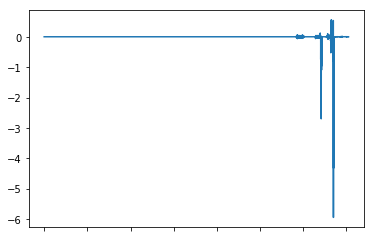

In [23]:
delta.plot()

In [24]:
delta.describe()

count    17622.000000
mean        -0.001809
std          0.072931
min         -5.947422
25%          0.000000
50%          0.000000
75%          0.000000
max          0.560502
Name: rainfall for SC #97, dtype: float64

In [25]:
relative = rel_i(200)
relative.describe()

count    8785.000000
mean             inf
std              NaN
min      -100.000000
25%         0.000000
50%         0.000000
75%         0.000000
max              inf
Name: rainfall for SC #97, dtype: float64